# **Fake And Real News Classification**

---

Authors: [Dennis Kimiri](), [Femi Kamau](https://www.github.com/ctrl-Karugu), [Monicah Iwagit](), [Teofilo Gafna](), [Wendy Mwiti](https://www.github.com/WendyMwiti)

## 1. Business Understanding

## 2. Data Understanding

Load Libraries

In [98]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn
import nltk
import re
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

Load Data

In [99]:
# Load the real news data
real = pd.read_csv('./data/True.csv')

# Load the fake news data
fake = pd.read_csv('./data/Fake.csv')

In [100]:
# Preview real data
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [101]:
# Preview the fake data
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [102]:
#  Add a column called 'category' to both DataFrames which will become our taget variable
real['category'] = 1
fake['category'] = 0

In [103]:
# Combine both DataFrames 
data = pd.concat([real, fake])

In [104]:
# Preview the new DataFrame
data

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [105]:
class understanding(object):
    """A class that does basic Data Understanding"""
    
    def __init__(self, df):
        self.shape = df.shape
      # self.info = df.info()
        self.duplicates = df.duplicated().sum()
        self.missing = df.isna().sum()
        self.types = df.dtypes
    
    def counts(self, df, col):
        """ A function that gets the value counts of a column"""
        self.counts = df[col].value_counts()
        return self.counts
    
    def nunique(self, df, col):
        """ A function that gets the number of unique values of a column"""
        self.unique = df[col].nunique()
        return self.nunique()
        
    def unique(self, df, col):
        """ A function that gets the unique values of a column"""
        self.unique = df[col].unique()
        return self.unique

In [106]:
# Instantiate the class
data_understanding = understanding(data)

In [107]:
# Summary of the dataset
print(data_understanding.shape)
data.info()

(44898, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


From the summary above, we can see that the dataset contain 44898 rows and spans 5 columns. The columns are: title, text, subject, date and category. The category column is the target variable and the rest are the features.

Furthermore, the dataset contains 4 object columns and 1 integer column. The object columns are: title, text, subject and date. The integer column is: category (target variable). We may need to convert the date column to datetime format in the data preparation phase.

The dataset does not contain any missing values.

In [108]:
# Check for duplicates
print(f"Duplicates: {data_understanding.duplicates}")

Duplicates: 209


The dataset contains 209 duplicates. They shall be inspected and removed if necessary in the data preparation phase.

In [109]:
# Check the number of missing values
data_understanding.missing

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [110]:
# Inspect the subject column
data['subject'].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

The articles that are within this dataset fall under 8 different subjects. These are: politicsNews, worldnews, News, politics, left-news, Government News, US_News, and Middle-east.

In [111]:
# Inspect the category column
data['category'].value_counts() / len(data) * 100

0    52.298543
1    47.701457
Name: category, dtype: float64

The dataset is fairly balanced between fake and real news 

In [112]:
# Inspect the date column
data['date'].nunique()

2397

The date column contains 2397 unique dates

## 3. Data Preparation


# Validity

To confirm that the data in each column matches a specified data type and format.


In [113]:
# converting date from object to datetime

data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')


In [114]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     44898 non-null  object        
 1   text      44898 non-null  object        
 2   subject   44898 non-null  object        
 3   date      44888 non-null  datetime64[ns]
 4   category  44898 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.1+ MB


In [115]:
data['date'].head()

0   2017-12-31
1   2017-12-29
2   2017-12-31
3   2017-12-30
4   2017-12-29
Name: date, dtype: datetime64[ns]

In [116]:
# extracting months and years

data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.strftime('%B')


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     44898 non-null  object        
 1   text      44898 non-null  object        
 2   subject   44898 non-null  object        
 3   date      44888 non-null  datetime64[ns]
 4   category  44898 non-null  int64         
 5   year      44888 non-null  float64       
 6   month     44888 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 2.7+ MB


In [118]:
# converting the subject column to category

data['subject'] = data['subject'].astype('category')

In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     44898 non-null  object        
 1   text      44898 non-null  object        
 2   subject   44898 non-null  category      
 3   date      44888 non-null  datetime64[ns]
 4   category  44898 non-null  int64         
 5   year      44888 non-null  float64       
 6   month     44888 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.4+ MB


# Consistency

To inspect the duplicates

In [120]:
duplicates  = data[data.duplicated()]
duplicates

,title,text,subject,date,category,year,month
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,2017-11-30,1,2017.0,November
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,2017-11-08,1,2017.0,November
892,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,2017-11-02,1,2017.0,November
896,Trump taps Fed centrist Powell to lead U.S. ce...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,2017-11-02,1,2017.0,November
974,"Two ex-Trump aides charged in Russia probe, th...",WASHINGTON (Reuters) - Federal investigators p...,politicsNews,2017-10-30,1,2017.0,October
...,...,...,...,...,...,...,...
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,2017-08-25,1,2017.0,August
21408,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,2017-08-22,1,2017.0,August
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,2017-09-09,0,2017.0,September
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,2017-03-10,0,2017.0,March


In [121]:

print(f" before: {len(data)}")
data.drop_duplicates(inplace=True)
print(f" after: {len(data)}")



 before: 44898
 after: 44689


# Completeness

From data understanding section we found there to be no missing values. Therefore we can confirm that the the dataset is complete.

# Uniformity

 To check on whether different systems refer to the same value in the same format

In [122]:
data['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [123]:
data['subject'].replace({'politicsNews': 'politics',
                         'worldnews': 'world_news',
                         'News': 'news',
                         'left-news': 'left_news',
                         'Government News': 'government_news',
                         'US_News': 'us_news',
                         'Middle-east': 'middle_east'}, inplace=True)


In [124]:
data['subject'].value_counts()

politics           18058
world_news          9991
news                9050
left_news           4459
government_news     1570
us_news              783
middle_east          778
Name: subject, dtype: int64

# Exploratory Data Analysis

## Univariate Analysis

In [125]:
# creating a function that plots the value counts of a column
def plot_bar(df, col):
    """ A function that returns a plot count of columns"""
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x = col, order=df[col].value_counts().index)
    plt.title(f"{col} count plot")
    plt.ylabel("count")
    plt.xticks(rotation=45)
    plt.show()
    

### Feature `subject`

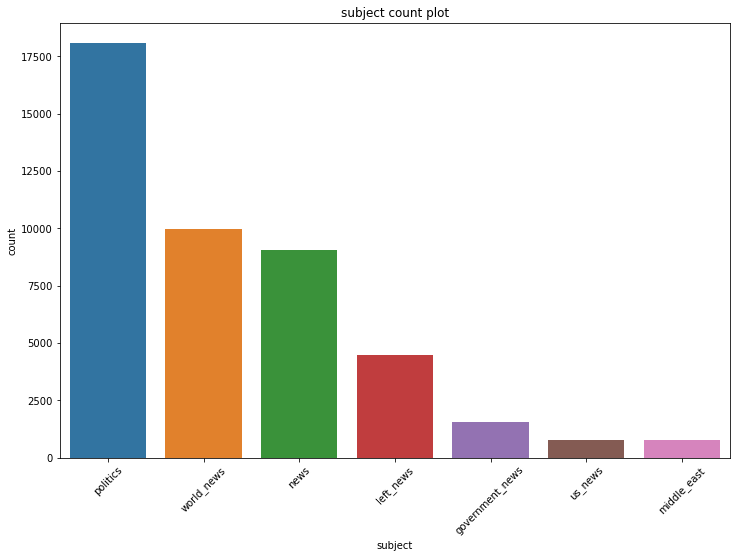

In [126]:
# Plotting a countplot of the subject
plot_bar(data, 'subject')

### Observations:
* Most of the published news talk about politics followed by world news while the least discussed subject is the Middle East

### Feature `month`

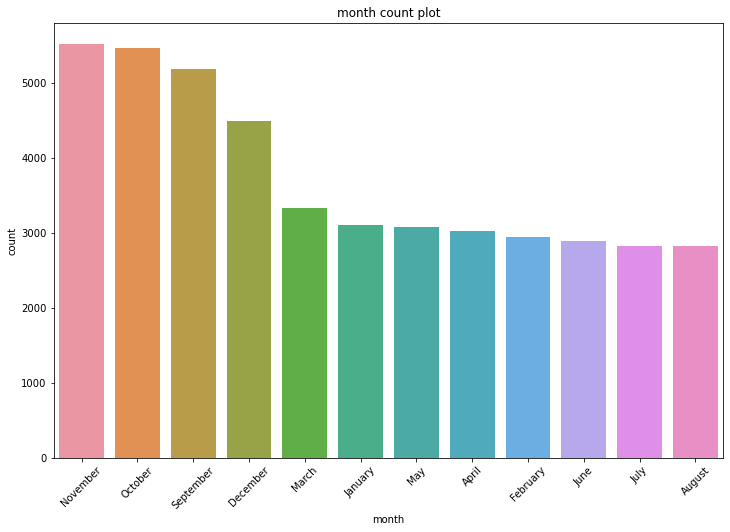

In [127]:
# Plotting a countplot of the months
plot_bar(data, 'month')

### Observations:
* Most of the news is published during the month of November followed by October and September.
* It is also worth noting that the months of September and October precede November.
* The month of August registered the least number of published news

### Feature `year`

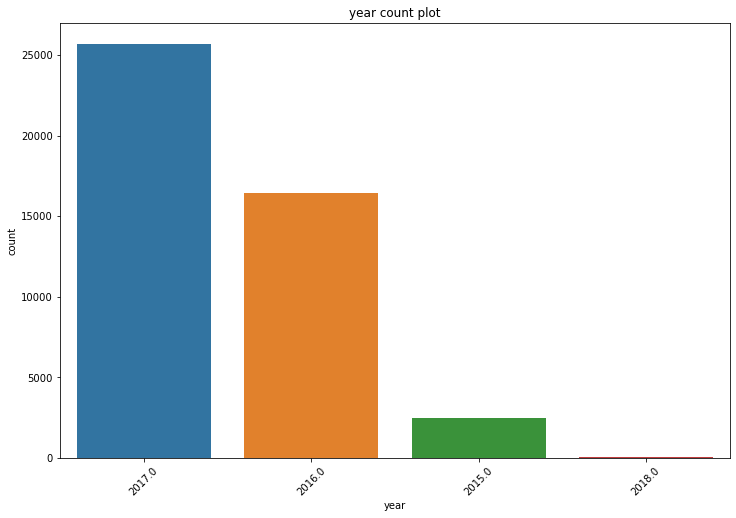

In [128]:
# Plotting the years
plot_bar(data, 'year')

### Observations:
* 2017 had the most news followed by 2016

### Feature `category`

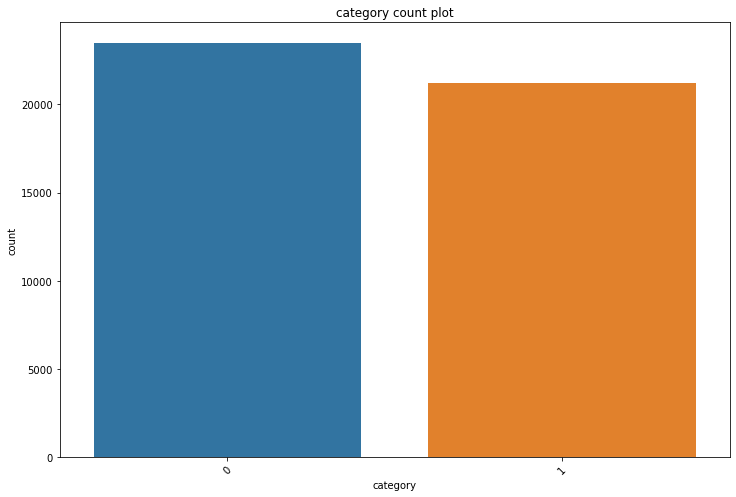

In [129]:
# Plotting fake vs Real news
plot_bar(data, 'category')

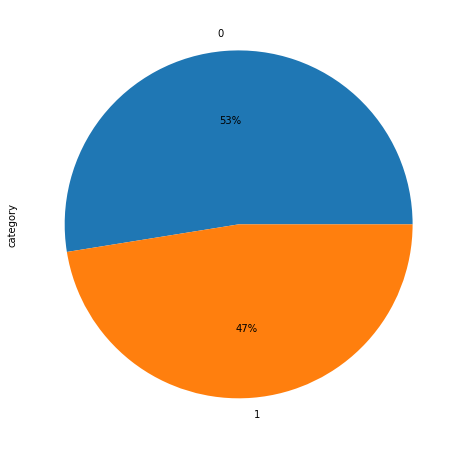

In [130]:
# Plotting a pie chart for the column 'category'
fig, ax = plt.subplots(figsize=(12,8))
data['category'].value_counts().plot(kind='pie', autopct='%.0f%%');

### Observations:
* The data set is fairly balanced. However, fake news is slightly more than real news.

## Bivariate Analysis

In [131]:
# Creating a function that plots a count plot with respect to another column
def plot_bivariate(df, col, by):
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x=col, hue=by)
    plt.title(f"{col} count plot by {by}")
    plt.ylabel("count")
    plt.xticks(rotation=45)
    plt.show()

### Feature `month` by `category`

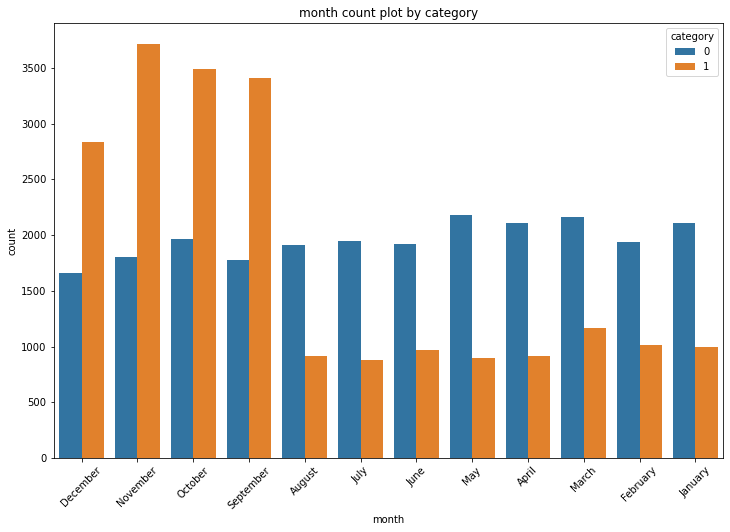

In [132]:
# Plotting month by category
plot_bivariate(data, 'month', 'category')

### Observations:
* 

### Feature `year` by `category`

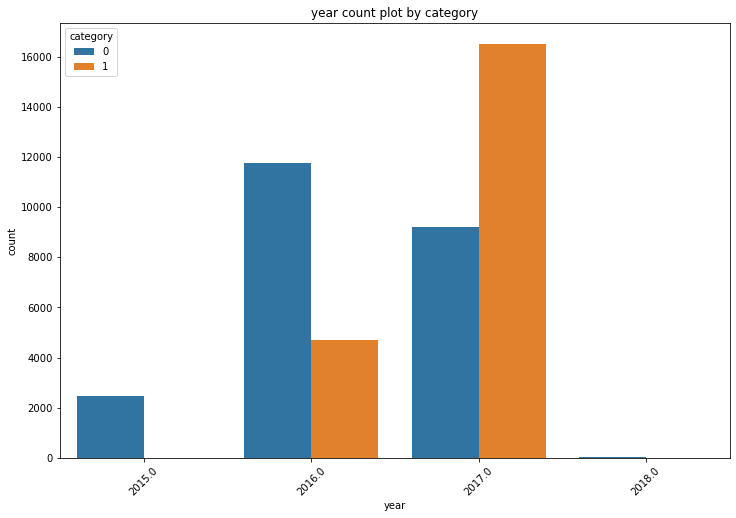

In [133]:
# plot year by category
plot_bivariate(data, 'year', 'category')

### Observations:
* 

### Feature `subject` by `category`

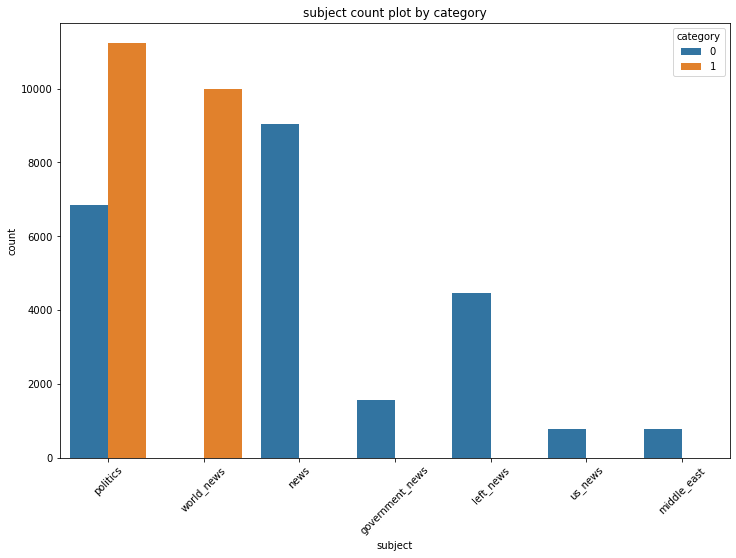

In [134]:
plot_bivariate(data, 'subject', 'category')

### Observations:
* 

In [135]:
# creating a function that plots a column versus another column
def plot_x_v_y(df, x, y):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-135-9faa6665658b>, line 3)

# Preprocessing

In [ ]:
# Dropping columns that will not be used in text classfication
data.drop(columns=['date', 'month', 'subject', 'year'], axis=1, inplace=True)
data.head()

In [ ]:
#reshuffling rows, resetting index
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.head()

In [137]:
#lowercasing
data['text'] = data['text'].str.lower()
data.head()

,title,text,subject,date,category,year,month
0,"As U.S. budget fight looms, Republicans flip t...",washington (reuters) - the head of a conservat...,politics,2017-12-31,1,2017.0,December
1,U.S. military to accept transgender recruits o...,washington (reuters) - transgender people will...,politics,2017-12-29,1,2017.0,December
2,Senior U.S. Republican senator: 'Let Mr. Muell...,washington (reuters) - the special counsel inv...,politics,2017-12-31,1,2017.0,December
3,FBI Russia probe helped by Australian diplomat...,washington (reuters) - trump campaign adviser ...,politics,2017-12-30,1,2017.0,December
4,Trump wants Postal Service to charge 'much mor...,seattle/washington (reuters) - president donal...,politics,2017-12-29,1,2017.0,December
